In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

import date_fixer

from googletrans import Translator

In [2]:
#example using translator Arabic to Engligh
translator = Translator()

translation = translator.translate("مرحبا كيف حالك؟",  dest='en')
translation.text

'Hello how are you?'

In [3]:
#example using translator English to Arabic
translator = Translator()

translation = translator.translate("Hello, how are you?",  dest='ar')
translation.text

'مرحبًاّ! كيف حالك؟'

In [4]:
new = pd.read_csv('daily8_5.csv')
new['dateline'] = pd.to_datetime(new['dateline'])
df = new
df.head()

,index,id,url,headline,dateline,text,tags,source,text_label,text_score,headline_label,headline_score
0,0,ETD_ARB_0000033,http://www.alittihad.ae/details.php?id=53&y=20...,الوثائق الرئاسية الأميركية··· متجاهلو التاريخ ...,2008-01-01,ربما نسي الكثيرون الآن الأمر التنفيذي الخاص با...,"['واشنطن', 'بوش']",Alittihad,False,False,negative,0.992800
1,1,ETD_ARB_0000035,http://www.alittihad.ae/details.php?id=55&y=20...,التنبؤات السنوية,2008-01-01,هذه هي حلقة التنبؤات المشتركة السنوية الرابعة ...,"['أوباما', 'كلينتون']",Alittihad,neutral,0.9615980386734009,neutral,0.974024
2,2,ETD_ARB_0000036,http://www.alittihad.ae/details.php?id=56&y=20...,شلهوب والحاسوب ·· يقدم وجبة تعليمية وفكرية ممت...,2008-01-01,''''كم هو جميل، هذا العالم السحري عالم الأطفال...,['بوش'],Alittihad,False,False,positive,0.836829
3,3,ETD_ARB_0000062,http://www.alittihad.ae/details.php?id=82&y=20...,48 قتيلاً وجريحاً باعتداءات متفرقة في العراق,2008-01-01,في استهداف جديد لعناصر ''''صحوة'''' العشائر ال...,['القاعدة'],Alittihad,neutral,0.8726907769838969,negative,0.701162
4,4,ETD_ARB_0000065,http://www.alittihad.ae/details.php?id=85&y=20...,النفط فوق 100 دولار·· هيلاري رئيسة لأميركا·· ا...,2008-01-01,استقبل العالم أول أيام العام الجديد ،2008 باحت...,['كلينتون'],Alittihad,neutral,0.9573821425437927,neutral,0.791736


In [5]:
def encode_sentiment(df, columns_to_encode):
    dummies_list = columns_to_encode

    dummy_df = pd.get_dummies(df[dummies_list], drop_first=False)
    encoded = pd.concat([df, dummy_df], axis = 1)
    return encoded

In [6]:
encoded = encode_sentiment(df, 'text_label')

<AxesSubplot:xlabel='dateline', ylabel='Count'>

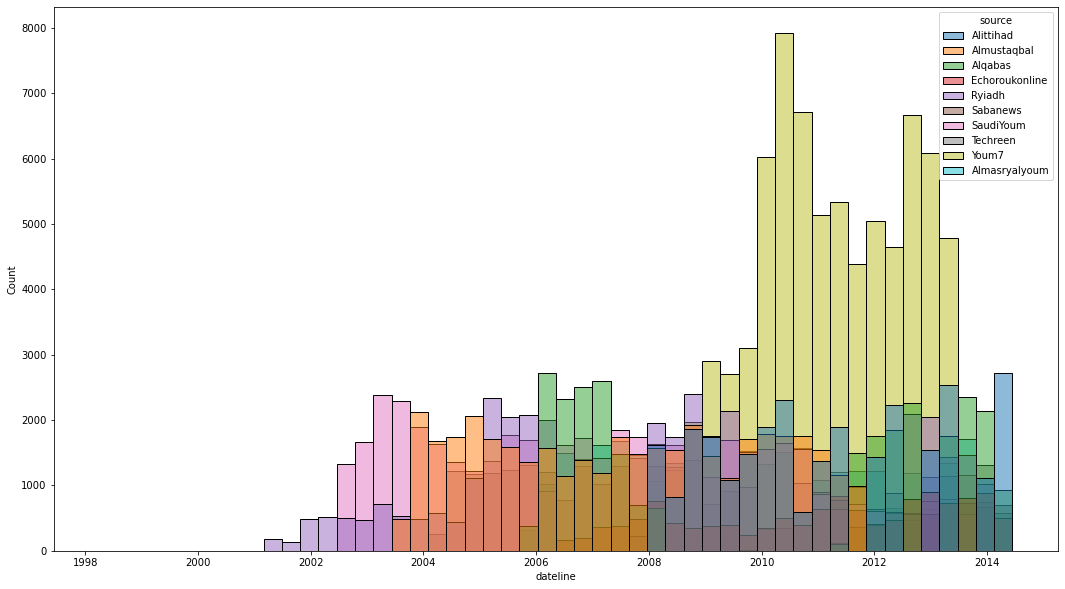

In [7]:
plt.figure(figsize = (18, 10))
sns.histplot(data=encoded, x='dateline', hue= 'source', bins=50)

<Figure size 1296x864 with 0 Axes>

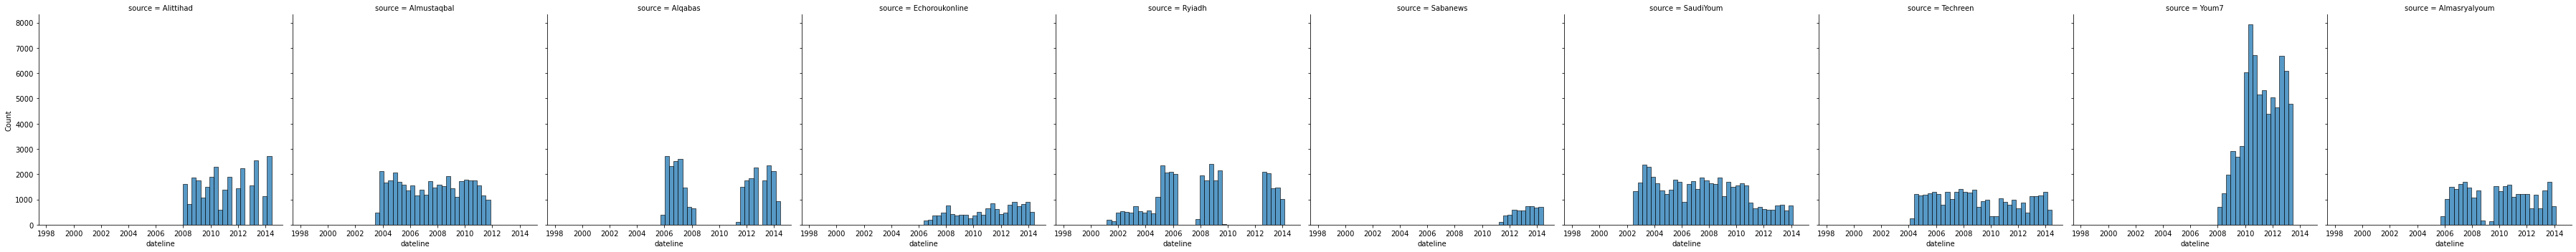

In [8]:
plt.figure(figsize = (18, 12))
sns.displot(data=encoded, x='dateline', col= 'source', bins=50)

In [9]:
df = encoded.set_index('dateline').sort_index()

In [10]:
df.columns

Index(['index', 'id', 'url', 'headline', 'text', 'tags', 'source',
       'text_label', 'text_score', 'headline_label', 'headline_score', 'False',
       'negative', 'neutral', 'positive'],
      dtype='object')

In [11]:
df.shape

(331870, 15)

In [12]:
df.info

<bound method DataFrame.info of             index               id  \
dateline                             
1998-04-02    124  MTL_ARB_0407176   
2000-01-31    254  RYD_ARB_0000002   
2001-03-05    178  RYD_ARB_0021558   
2001-03-11    177  RYD_ARB_0021555   
2001-03-13    175  RYD_ARB_0021553   
...           ...              ...   
2014-06-14     24  ETD_ARB_0349009   
2014-06-15     53  ETD_ARB_0349291   
2014-06-15     54  ETD_ARB_0349298   
2014-06-15     55  ETD_ARB_0349301   
2014-06-15     56  ETD_ARB_0349339   

                                                          url  \
dateline                                                        
1998-04-02  http://www.almustaqbal.com/v4/article.aspx?typ...   
2000-01-31  http://www.alriyadh.com/2000/01/31/article7998...   
2001-03-05  http://www.alriyadh.com/2001/03/05/article3376...   
2001-03-11  http://www.alriyadh.com/2001/03/11/article3376...   
2001-03-13  http://www.alriyadh.com/2001/03/13/article3375...   
...               

In [13]:
df.headline_label.value_counts()

neutral     232890
negative     75476
positive     23504
Name: headline_label, dtype: int64

In [14]:
df.tags.value_counts()

['واشنطن']                                                        56382
['القاعدة']                                                       53674
['أمريكا']                                                        53188
['بوش']                                                           44362
['أوباما']                                                        17050
                                                                  ...  
['أمريكا', 'واشنطن', 'أوباما', 'كلينتون', 'آل غور', 'القاعدة']        1
['أمريكا', 'واشنطن', 'بوش', 'تشيني', '11 سبتمبر', 'القاعدة']          1
['واشنطن', 'بوش', 'أوباما', 'كلينتون', 'غوغل']                        1
['واشنطن', 'بوش', 'أوباما', 'آل غور', 'القاعدة']                      1
['واشنطن', 'بوش', 'فيسبوك', 'القاعدة']                                1
Name: tags, Length: 977, dtype: int64

In [15]:
df.text_label.value_counts()

neutral     172544
False        94164
negative     54450
positive     10712
Name: text_label, dtype: int64

In [16]:
df.source.value_counts()

Youm7             75355
SaudiYoum         48972
Almustaqbal       39585
Ryiadh            32906
Techreen          31643
Almasryalyoum     28715
Alittihad         28256
Alqabas           27998
Echoroukonline    12999
Sabanews           5441
Name: source, dtype: int64

### Sources - Background info on them. Any major events that could cause sentiment, are they government or privately owned?

Al Qabas - Founded	22 February 1972; 50 years ago, Kuwait. Political alignment is defined as Liberal. Private owned.
The paper's editor, Mohammed Al-Sager, is a winner of the International Press Freedom Award of the Committee to Protect Journalists "for courageous reporting on political and human rights issues in the face of government threats of censorship and prosecution". The other significant editors of the daily include Abdel Latif Al Duaaij and Ahmad Bishara.
The Palestinian cartoonist Naji Salim al-Ali worked for the paper in the 1980s and he was killed in 1987 while working for the London edition of the daily.


Echoroukonline (Echorouk or Ech Chorouk El Youmi) - Daily Tabloid/Newspaper, Algeria. It is independent. in a fall 2006 trial, the leader of neighbouring Libya, Muammar Gaddafi, took the unprecedented step of suing the paper in an Algerian court for defamation. Independent, private.


Al-Ittihad(Emirati newspaper) - Publisher: Al Ittihad Press and Publishing Corporation, United Arab Emirates. The paper is the first regular publication of the country.It is part of the Abu Dhabi Media group, a government organization.

Ryiadh - Al Riyadh (Arabic: الرياض) is a Riyadh-based, pro-government Saudi daily newspaper. Its sister paper was Riyadh Daily that was in circulation between 2003 and 1 January 2004. Al Riyadh is officially independent in that it is being published by a private company. 

Saudiyoum - Although the daily is described as pro-government it has experienced suspensions and arrests of its correspondents.

Al-Mustaqbal - ('The Future') is an Arabic language online newspaper in Lebanon, headquartered in Beirut and is an official publication of the Future Movement. Al Mustaqbal was launched in 1999 by Rafic Hariri, former Prime Minister and assassinated leader of the Future Movement. The paper ended publication in 2019. Hariri was assassinated on Feb 14th, 2005. Private.

Techreen - State owned.

Youm7 - The paper's politicized coverage since the 2011 Egyptian Revolution has led to calls for its boycott. Online activists in Egypt also accused the paper of fabricating news and spreading misinformation, and at one point urged Twitter users to unfollow any profiles associated with the paper. As of September 2020, Youm7 was owned by Egyptian Media Group, which was owned by United Media Services Group, which was itself owned by one of the Egyptian intelligence agencies (Mukhabarat, military intelligence, National Security Agency). Meaning, its NOW government owned but we are not sure of before.

Sabanews - State owned.

Almasryalyoum - Private. The paper has a liberal leaning.

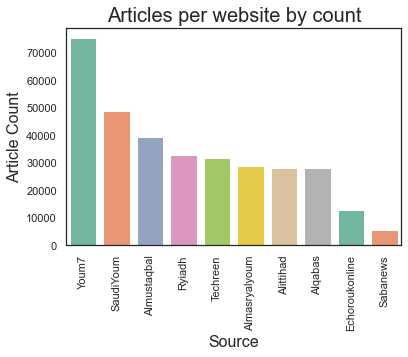

In [17]:
sns.set_theme(style="white")
ax = sns.countplot(x="source", data=df, palette="Set2",order = new['source'].value_counts().index)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Source', size = 16)
ax.set_ylabel('Article Count', size = 16)
ax.set_title("Articles per website by count", size = 20)
plt.show()

In [18]:
def country_tagger(df):
    country_map = { 'Alittihad': 'emirates',
                    'Echoroukonline': 'algeria',
                    'Ryiadh': 'ksa',
                    'SaudiYoum': 'ksa',
                    'Techreen': 'syria',
                    'Alqabas': 'kuwait',
                    'Almustaqbal': 'lebanon',
                    'Almasryalyoum': 'egypt',
                    'Youm7': 'egypt',
                    'Sabanews': 'yemen',
                    }
    df['country'] = df.source.map(country_map)
    return df

In [19]:
country_tagger(df)

,index,id,url,headline,text,tags,source,text_label,text_score,headline_label,headline_score,False,negative,neutral,positive,country
dateline,,,,,,,,,,,,,,,,
1998-04-02,124,MTL_ARB_0407176,http://www.almustaqbal.com/v4/article.aspx?typ...,"بوش يستقبل صفير """"صوت الاستقلال والحرية""""",أعلن البيت الأبيض أن الرئيس الأميركي جورج بوش ...,"['واشنطن', 'بوش']",Almustaqbal,neutral,0.9444249272346497,neutral,0.993730,0,0,1,0,lebanon
2000-01-31,254,RYD_ARB_0000002,http://www.alriyadh.com/2000/01/31/article7998...,رجل القرن العربي,تركي بن عبد الله السديري\n* نجوم الفن الذين يح...,['القاعدة'],Ryiadh,False,False,neutral,0.710204,1,0,0,0,ksa
2001-03-05,178,RYD_ARB_0021558,http://www.alriyadh.com/2001/03/05/article3376...,الفضاء والصحافة خطر على المنتخب!!,أحمد المصيبيح\n* تناول بعض الإعلاميين سواء في ...,['القاعدة'],Ryiadh,negative,0.7945764859517416,negative,0.946199,0,1,0,0,ksa
2001-03-11,177,RYD_ARB_0021555,http://www.alriyadh.com/2001/03/11/article3376...,احتراق لاعب سعودي!!,تركي العواد\nالتقيت قبل عدة ايام بالنجم الخلوق...,['أمريكا'],Ryiadh,False,False,negative,0.930776,1,0,0,0,ksa
2001-03-13,175,RYD_ARB_0021553,http://www.alriyadh.com/2001/03/13/article3375...,الخروج عن النص,بدرية البشر\n* أرادت المعلمة أن تخرج عن النص ا...,"['بوش', 'كلينتون']",Ryiadh,negative,0.8764036496480306,negative,0.819218,0,1,0,0,ksa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-14,24,ETD_ARB_0349009,http://www.alittihad.ae/details.php?id=52631&y...,التصميم الجديد لـ «سكايب» متوافر الآن لأجهزة آ...,أعلنت شركة مايكروسوفت أمس، وصول تطبيق سكايب بت...,['واشنطن'],Alittihad,neutral,0.8458304405212402,neutral,0.702675,0,0,1,0,emirates
2014-06-15,53,ETD_ARB_0349291,http://www.alittihad.ae/details.php?id=52931&y...,تسريب موعد إطلاق GTA V للحاسب والجيل الجديد,قام متجر «أمازون» بتسريب موعد إطلاق نسخة الجيل...,['واشنطن'],Alittihad,neutral,0.9036186337471008,neutral,0.995331,0,0,1,0,emirates
2014-06-15,54,ETD_ARB_0349298,http://www.alittihad.ae/details.php?id=52938&y...,رحيل مغني الجاز جيمي عن 88 عاماً,توفي مغني الجاز الأميركي جيمي سكوت عن 88 عاما،...,['واشنطن'],Alittihad,neutral,0.7956603169441223,negative,0.796956,0,0,1,0,emirates


## What’s the relationship between article sentiment and world events?

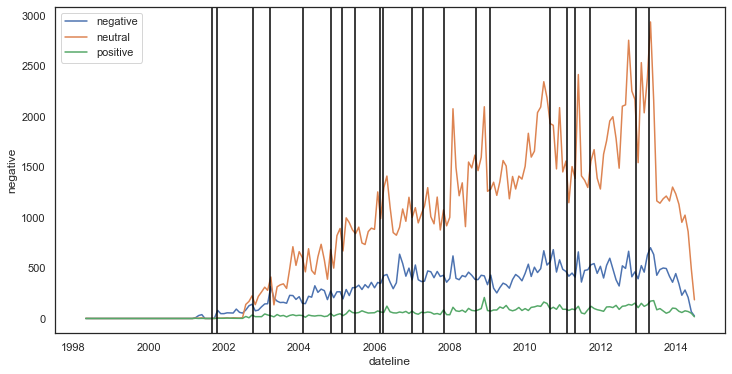

In [20]:
plt.figure(figsize = (12, 6))
sns.lineplot(data = df.resample('1M').sum(), x = 'dateline', y = 'negative', label = 'negative')
sns.lineplot(data = df.resample('1M').sum(), x = 'dateline', y = 'neutral', label = 'neutral')
sns.lineplot(data = df.resample('1M').sum(), x = 'dateline', y = 'positive', label = 'positive')
plt.axvline(dt.datetime(2001, 9, 11),  color = 'black') ## 9/11
plt.axvline(dt.datetime(2001, 10, 22), color = 'black') ## US leads assault on Taliban in Afghanistan
plt.axvline(dt.datetime(2002, 10, 11), color = 'black') ## Congress authorizes forces against Iraq
plt.axvline(dt.datetime(2003, 3, 19), color = 'black') ## US invades Iraq, starting war
plt.axvline(dt.datetime(2004, 2, 4), color = 'black') ## Facebook is formed
plt.axvline(dt.datetime(2004, 11, 7), color = 'black') ## Start of the Second Battle of Fallujah
plt.axvline(dt.datetime(2005, 2, 14), color = 'black') ## Youtube is created
plt.axvline(dt.datetime(2005, 6, 23), color = 'black') ## Reddit is created
plt.axvline(dt.datetime(2006, 2, 22), color = 'black') ## al-Askari Mosque bombing, Start of Iraqi War
plt.axvline(dt.datetime(2006, 3, 21), color = 'black') ## Twitter is created
plt.axvline(dt.datetime(2006, 12, 30), color = 'black') ## Saddam Hussein executed
plt.axvline(dt.datetime(2007, 4, 16), color = 'black') ## Virginia Tech Mass Shooting
plt.axvline(dt.datetime(2007, 11, 4), color = 'black') ## Barack officially elected president
plt.axvline(dt.datetime(2008, 9, 15), color = 'black') ## Start of Great Recession
plt.axvline(dt.datetime(2009, 1, 20), color = 'black') ## Barack Obama elected first black president
plt.axvline(dt.datetime(2010, 8, 30), color = 'black') ## US combat roll in Iraq ends
plt.axvline(dt.datetime(2011, 2, 14), color = 'black') ## Start of Arab Spring
plt.axvline(dt.datetime(2011, 5, 2), color = 'black') ## Navy Seals take down Osama Bin Laden
plt.axvline(dt.datetime(2011, 9, 19), color = 'black') ## Occupy Wallstreet
plt.axvline(dt.datetime(2012, 12, 14), color = 'black') ## Sandy Hook Shooting
plt.axvline(dt.datetime(2013, 4, 15), color = 'black') ## Boston Marathon Bombing


plt.legend()

Takeaways:

- 2006 - Peak matches up with Saddam Hussein execution.
- 2008 - Huge peak at beginning of year, from what??
- End of 2010 - Peak and overal increase right before Arab Spring
- Very steady articles 2012 to peak in 2013. Peak in 2013 almost exactly matches Boston Marathon timing.

## What is the relationship between tag and target (text_labels)

In [21]:
df.tags.value_counts()

['واشنطن']                                                        56382
['القاعدة']                                                       53674
['أمريكا']                                                        53188
['بوش']                                                           44362
['أوباما']                                                        17050
                                                                  ...  
['أمريكا', 'واشنطن', 'أوباما', 'كلينتون', 'آل غور', 'القاعدة']        1
['أمريكا', 'واشنطن', 'بوش', 'تشيني', '11 سبتمبر', 'القاعدة']          1
['واشنطن', 'بوش', 'أوباما', 'كلينتون', 'غوغل']                        1
['واشنطن', 'بوش', 'أوباما', 'آل غور', 'القاعدة']                      1
['واشنطن', 'بوش', 'فيسبوك', 'القاعدة']                                1
Name: tags, Length: 977, dtype: int64

In [22]:
df.tags.nunique()

977

In [23]:
tag_count = dict(df['tags'].value_counts())
df['tag_count'] = df['tags']
df['tag_count'] = df['tag_count'].map(tag_count)

tags = df[df.tag_count > 50]

In [24]:
tags.tags.nunique() 

127

In [25]:
tags.head()

,index,id,url,headline,text,tags,source,text_label,text_score,headline_label,headline_score,False,negative,neutral,positive,country,tag_count
dateline,,,,,,,,,,,,,,,,,
1998-04-02,124,MTL_ARB_0407176,http://www.almustaqbal.com/v4/article.aspx?typ...,"بوش يستقبل صفير """"صوت الاستقلال والحرية""""",أعلن البيت الأبيض أن الرئيس الأميركي جورج بوش ...,"['واشنطن', 'بوش']",Almustaqbal,neutral,0.9444249272346497,neutral,0.993730,0,0,1,0,lebanon,12164
2000-01-31,254,RYD_ARB_0000002,http://www.alriyadh.com/2000/01/31/article7998...,رجل القرن العربي,تركي بن عبد الله السديري\n* نجوم الفن الذين يح...,['القاعدة'],Ryiadh,False,False,neutral,0.710204,1,0,0,0,ksa,53674
2001-03-05,178,RYD_ARB_0021558,http://www.alriyadh.com/2001/03/05/article3376...,الفضاء والصحافة خطر على المنتخب!!,أحمد المصيبيح\n* تناول بعض الإعلاميين سواء في ...,['القاعدة'],Ryiadh,negative,0.7945764859517416,negative,0.946199,0,1,0,0,ksa,53674
2001-03-11,177,RYD_ARB_0021555,http://www.alriyadh.com/2001/03/11/article3376...,احتراق لاعب سعودي!!,تركي العواد\nالتقيت قبل عدة ايام بالنجم الخلوق...,['أمريكا'],Ryiadh,False,False,negative,0.930776,1,0,0,0,ksa,53188
2001-03-13,175,RYD_ARB_0021553,http://www.alriyadh.com/2001/03/13/article3375...,الخروج عن النص,بدرية البشر\n* أرادت المعلمة أن تخرج عن النص ا...,"['بوش', 'كلينتون']",Ryiadh,negative,0.8764036496480306,negative,0.819218,0,1,0,0,ksa,887


In [26]:
df = tags

topics = {'America' : 'أمريكا',
            'American' : 'أمريكيّ',
            'American (f)' : 'أمريكيّة',
            'American (pl)' : 'أمريكيّين',
            'The United States' : 'الولايات المتحدة',
            'The United States' : 'دول موحّدة',
            'Washington' : 'واشنطن',
            'Bush' : 'بوش',
            'Obama' : 'أوباما',
            'Cheney' : 'تشيني',
            'Clinton' : 'كلينتون',
            'Osama Bin Laden' : 'أسامة بن لادن',
            'Al Gore' : 'آل غور',
            'World Trade Center' : 'مركز التجارة العالمي',
            '9/11' : '9/11',
            'September 11' : '11 سبتمبر',
            'Gulf War' : 'حرب الخليج',
            'Google' : 'غوغل',
            'Facebook' : 'فيسبوك',
            'Al Qaida' : 'القاعدة'}

In [27]:
def flip_key_value_pairs(dicts):
    
    res = dict((v,k) for k,v in dicts.items())    
    return res


def make_eng_tags(df_tags):
    eng_tags =[]
    
    rev_topics = flip_key_value_pairs(topics)
    for key, value in rev_topics.items():
        if key in df_tags:
            eng_tags.append(value)
            
    return eng_tags

df['english_tags'] = tags.tags.apply(make_eng_tags)

In [28]:
df

,index,id,url,headline,text,tags,source,text_label,text_score,headline_label,headline_score,False,negative,neutral,positive,country,tag_count,english_tags
dateline,,,,,,,,,,,,,,,,,,
1998-04-02,124,MTL_ARB_0407176,http://www.almustaqbal.com/v4/article.aspx?typ...,"بوش يستقبل صفير """"صوت الاستقلال والحرية""""",أعلن البيت الأبيض أن الرئيس الأميركي جورج بوش ...,"['واشنطن', 'بوش']",Almustaqbal,neutral,0.9444249272346497,neutral,0.993730,0,0,1,0,lebanon,12164,"[Washington, Bush]"
2000-01-31,254,RYD_ARB_0000002,http://www.alriyadh.com/2000/01/31/article7998...,رجل القرن العربي,تركي بن عبد الله السديري\n* نجوم الفن الذين يح...,['القاعدة'],Ryiadh,False,False,neutral,0.710204,1,0,0,0,ksa,53674,[Al Qaida]
2001-03-05,178,RYD_ARB_0021558,http://www.alriyadh.com/2001/03/05/article3376...,الفضاء والصحافة خطر على المنتخب!!,أحمد المصيبيح\n* تناول بعض الإعلاميين سواء في ...,['القاعدة'],Ryiadh,negative,0.7945764859517416,negative,0.946199,0,1,0,0,ksa,53674,[Al Qaida]
2001-03-11,177,RYD_ARB_0021555,http://www.alriyadh.com/2001/03/11/article3376...,احتراق لاعب سعودي!!,تركي العواد\nالتقيت قبل عدة ايام بالنجم الخلوق...,['أمريكا'],Ryiadh,False,False,negative,0.930776,1,0,0,0,ksa,53188,[America]
2001-03-13,175,RYD_ARB_0021553,http://www.alriyadh.com/2001/03/13/article3375...,الخروج عن النص,بدرية البشر\n* أرادت المعلمة أن تخرج عن النص ا...,"['بوش', 'كلينتون']",Ryiadh,negative,0.8764036496480306,negative,0.819218,0,1,0,0,ksa,887,"[Bush, Clinton]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-14,24,ETD_ARB_0349009,http://www.alittihad.ae/details.php?id=52631&y...,التصميم الجديد لـ «سكايب» متوافر الآن لأجهزة آ...,أعلنت شركة مايكروسوفت أمس، وصول تطبيق سكايب بت...,['واشنطن'],Alittihad,neutral,0.8458304405212402,neutral,0.702675,0,0,1,0,emirates,56382,[Washington]
2014-06-15,53,ETD_ARB_0349291,http://www.alittihad.ae/details.php?id=52931&y...,تسريب موعد إطلاق GTA V للحاسب والجيل الجديد,قام متجر «أمازون» بتسريب موعد إطلاق نسخة الجيل...,['واشنطن'],Alittihad,neutral,0.9036186337471008,neutral,0.995331,0,0,1,0,emirates,56382,[Washington]
2014-06-15,54,ETD_ARB_0349298,http://www.alittihad.ae/details.php?id=52938&y...,رحيل مغني الجاز جيمي عن 88 عاماً,توفي مغني الجاز الأميركي جيمي سكوت عن 88 عاما،...,['واشنطن'],Alittihad,neutral,0.7956603169441223,negative,0.796956,0,0,1,0,emirates,56382,[Washington]


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 326895 entries, 1998-04-02 to 2014-06-15
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           326895 non-null  int64  
 1   id              326895 non-null  object 
 2   url             326895 non-null  object 
 3   headline        326895 non-null  object 
 4   text            326895 non-null  object 
 5   tags            326895 non-null  object 
 6   source          326895 non-null  object 
 7   text_label      326895 non-null  object 
 8   text_score      326895 non-null  object 
 9   headline_label  326895 non-null  object 
 10  headline_score  326895 non-null  float64
 11  False           326895 non-null  uint8  
 12  negative        326895 non-null  uint8  
 13  neutral         326895 non-null  uint8  
 14  positive        326895 non-null  uint8  
 15  country         326895 non-null  object 
 16  tag_count       326895 non-null  int64  

In [30]:
df.english_tags.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Washington]                                          56382
[Al Qaida]                                            53674
[America]                                             53188
[Bush]                                                44362
[Obama]                                               17050
                                                      ...  
[America, Washington, September 11, Al Qaida]            56
[Bush, Cheney, Clinton]                                  55
[America, Bush, Obama, Al Qaida]                         54
[World Trade Center, Al Qaida]                           53
[America, Osama Bin Laden, September 11, Al Qaida]       51
Name: english_tags, Length: 127, dtype: int64

In [31]:
df = df.dropna()

In [32]:
df['english_tags']

dateline
1998-04-02    [Washington, Bush]
2000-01-31            [Al Qaida]
2001-03-05            [Al Qaida]
2001-03-11             [America]
2001-03-13       [Bush, Clinton]
                     ...        
2014-06-14          [Washington]
2014-06-15          [Washington]
2014-06-15          [Washington]
2014-06-15          [Washington]
2014-06-15          [Washington]
Name: english_tags, Length: 326895, dtype: object

In [33]:
df['string_tags'] = df['english_tags'].apply(lambda x: ','.join(map(str, x)))

In [34]:
df['string_tags'].unique()

array(['Washington,Bush', 'Al Qaida', 'America', 'Bush,Clinton',
       'America,Washington', 'America,Al Qaida', 'Washington', 'Clinton',
       'Bush', 'America,Washington,Bush', 'Gulf War', 'Bush,Al Qaida',
       'America,Gulf War', 'America,Bush', 'America,Bush,Clinton',
       'America,Clinton', 'Washington,Clinton', 'Washington,Bush,Clinton',
       'Washington,Bush,Clinton,Al Qaida', 'America,Washington,Al Qaida',
       '9/11', 'Washington,Bush,Al Qaida',
       'America,Washington,Bush,Al Qaida', 'America,Osama Bin Laden',
       'World Trade Center',
       'America,Washington,Osama Bin Laden,Al Qaida',
       'Washington,Gulf War', 'Washington,Bush,Cheney,Al Qaida',
       'Osama Bin Laden,Al Qaida', 'Washington,Al Qaida',
       'Washington,Bush,Gulf War', 'Bush,Osama Bin Laden',
       'America,Osama Bin Laden,Al Qaida', 'America,Washington,Clinton',
       'America,Bush,Al Qaida', 'America,September 11',
       'Gulf War,Al Qaida', 'September 11', 'America,Bush,Gulf War'

#### Other work
***

In [35]:
encoded['article'] = 1
encoded

,index,id,url,headline,dateline,text,tags,source,text_label,text_score,headline_label,headline_score,False,negative,neutral,positive,article
0,0,ETD_ARB_0000033,http://www.alittihad.ae/details.php?id=53&y=20...,الوثائق الرئاسية الأميركية··· متجاهلو التاريخ ...,2008-01-01,ربما نسي الكثيرون الآن الأمر التنفيذي الخاص با...,"['واشنطن', 'بوش']",Alittihad,False,False,negative,0.992800,1,0,0,0,1
1,1,ETD_ARB_0000035,http://www.alittihad.ae/details.php?id=55&y=20...,التنبؤات السنوية,2008-01-01,هذه هي حلقة التنبؤات المشتركة السنوية الرابعة ...,"['أوباما', 'كلينتون']",Alittihad,neutral,0.9615980386734009,neutral,0.974024,0,0,1,0,1
2,2,ETD_ARB_0000036,http://www.alittihad.ae/details.php?id=56&y=20...,شلهوب والحاسوب ·· يقدم وجبة تعليمية وفكرية ممت...,2008-01-01,''''كم هو جميل، هذا العالم السحري عالم الأطفال...,['بوش'],Alittihad,False,False,positive,0.836829,1,0,0,0,1
3,3,ETD_ARB_0000062,http://www.alittihad.ae/details.php?id=82&y=20...,48 قتيلاً وجريحاً باعتداءات متفرقة في العراق,2008-01-01,في استهداف جديد لعناصر ''''صحوة'''' العشائر ال...,['القاعدة'],Alittihad,neutral,0.8726907769838969,negative,0.701162,0,0,1,0,1
4,4,ETD_ARB_0000065,http://www.alittihad.ae/details.php?id=85&y=20...,النفط فوق 100 دولار·· هيلاري رئيسة لأميركا·· ا...,2008-01-01,استقبل العالم أول أيام العام الجديد ،2008 باحت...,['كلينتون'],Alittihad,neutral,0.9573821425437927,neutral,0.791736,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331865,352,MTL_ARB_0409302,http://www.almustaqbal.com/v4/article.aspx?typ...,كونغ فو: كأس لبنان لفئة الصغار المرحلة الثانية,2005-03-18,نظم اتحاد الكونغ فو المرحلة الثانية من بطولة ل...,['بوش'],Almustaqbal,neutral,0.9892895817756653,neutral,0.994642,0,0,1,0,1
331866,353,MTL_ARB_0409311,http://www.almustaqbal.com/v4/article.aspx?typ...,"الـ""""سي آي ايه"""": سوريا وايران تقوّضان جهود أم...",2005-03-18,"اتهم مدير """"وكالة المخابرات المركزية الأميركية...",['القاعدة'],Almustaqbal,negative,0.6896247069040934,neutral,0.957517,0,1,0,0,1
331867,354,MTL_ARB_0409312,http://www.almustaqbal.com/v4/article.aspx?typ...,"""""النواب الأميركي"""" يقر """"تحرير لبنان وسوريا""""",2005-03-18,تبنى مجلس النواب الأميركي أمس بما يشبه الإجماع...,['بوش'],Almustaqbal,neutral,0.8265988826751709,neutral,0.982902,0,0,1,0,1
331868,355,MTL_ARB_0409313,http://www.almustaqbal.com/v4/article.aspx?typ...,"إجماع على اعتباره """"هجوم النزع الأخير"""" والحري...",2005-03-18,صفير في واشنطن يؤكد على الانسحاب قبل الانتخابا...,['واشنطن'],Almustaqbal,False,False,neutral,0.698540,1,0,0,0,1
